In [1]:
import sys
sys.path.append("../")
import engarde.decorators as ed


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from functools import reduce
from patsy import dmatrices
import statsmodels.formula.api as smf

from library import test

In [2]:
@ed.verify(test.onlyeligible)
def load(data):
    return data

In [8]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/descriptive/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'cits.csv'),
                  sep=",", low_memory=False)
data = load(data)
data.head()
data = data[['distname', 'district', 'treat', 'year', 'students_hisp', 'type_rural', 'type_suburban', 'type_urban', 'students_num', 'avescores']]
data.reset_index().head()

,index,distname,district,treat,year,students_hisp,type_rural,type_suburban,type_urban,students_num,avescores
0,0,CAYUGA ISD,1902,1,2012,0.050847,1,0,0,590,0.377578
1,1,ELKHART ISD,1903,1,2012,0.078678,0,0,0,1271,-0.059507
2,2,FRANKSTON ISD,1904,1,2012,0.103683,1,0,0,733,-0.192849
3,3,NECHES ISD,1906,1,2012,0.099256,1,0,0,403,0.786920
4,4,PALESTINE ISD,1907,1,2012,0.389752,0,0,0,3220,-0.580319


In [12]:
df_dist = data[data.year == 2016][['district', 'distname', 'treat', 'type_rural', 'type_suburban', 'type_urban']]
df_12 = data[data.year == 2012][['district',  'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp12', 'students_num': 'num12', 'avescores': 'scores12'})
df_13 = data[data.year == 2013][['district', 'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp13', 'students_num': 'num13', 'avescores': 'scores13'})
df_14 = data[data.year == 2014][['district', 'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp14', 'students_num': 'num14', 'avescores': 'scores14'})
df_15 = data[data.year == 2015][['district', 'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp15', 'students_num': 'num15', 'avescores': 'scores15'})
df = reduce(lambda x, y: pd.merge(x, y, how = 'inner', on = ['district']), [df_dist, df_12, df_13, df_14, df_15])
load(df)
df.tail()

,district,distname,treat,type_rural,type_suburban,type_urban,hisp12,num12,scores12,hisp13,num13,scores13,hisp14,num14,scores14,hisp15,num15,scores15
919,252901,GRAHAM ISD,1,0,0,0,0.254257,2525,-0.138235,0.264180,2574,0.093954,0.286547,2572,-0.001845,0.304731,2494,0.148576
920,252902,NEWCASTLE ISD,1,1,0,0,0.095745,188,0.716070,0.128205,195,0.669549,0.132701,211,0.803144,0.100000,210,0.674338
921,252903,OLNEY ISD,1,1,0,0,0.369681,752,0.216041,0.372654,746,0.134101,0.362117,718,0.223856,0.365517,725,0.714181
922,253901,ZAPATA COUNTY ISD,1,0,1,0,0.990449,3455,-0.935907,0.988842,3585,-0.923116,0.991101,3596,-1.031049,0.989937,3677,-1.153354
923,254902,LA PRYOR ISD,1,1,0,0,0.944325,467,-1.295432,0.941788,481,-1.242104,0.928571,476,-1.212341,0.939959,483,-0.961327


# Propensity Scores without test scores

In [13]:
y, X = dmatrices('treat ~ type_rural + type_suburban + type_urban + hisp12 + hisp13 + hisp14 + hisp15 + num12 + num13 + num14 + num15',
                 data=df, return_type='dataframe', NA_action = "drop")
mod = smf.Logit(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model
df['ps1'] = res.predict(X)

Optimization terminated successfully.
         Current function value: 0.425028
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  924
Model:                          Logit   Df Residuals:                      912
Method:                           MLE   Df Model:                           11
Date:                Thu, 18 Apr 2019   Pseudo R-squ.:                 0.07775
Time:                        11:48:21   Log-Likelihood:                -392.73
converged:                       True   LL-Null:                       -425.84
                                        LLR p-value:                 6.348e-10
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.5627      0.247     10.368      0.000       2.078       3.047
type_rural       -0.

## Plot Overlap

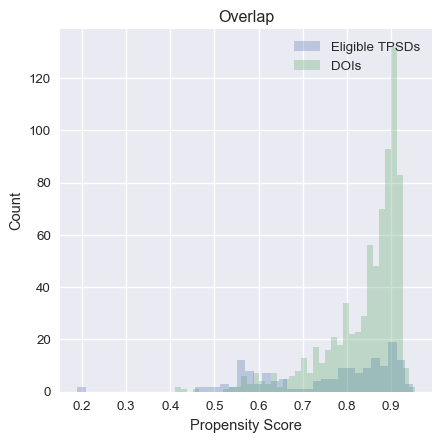

In [14]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)


kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
plt.hist(df[(df.treat == 0) & (pd.notnull(df.ps1))].ps1, **kwargs, label = "Eligible TPSDs")
plt.hist(df[(df.treat == 1) & (pd.notnull(df.ps1))].ps1, **kwargs, label = "DOIs")

plt.legend()


plt.xlabel('Propensity Score')
plt.title('Overlap')
plt.ylabel('Count')
plt.show()


## Weight

In [21]:
df['psweight1'] = np.where((df.treat == True), 1/df.ps1, 1/(1-df.ps1))
sum(df.psweight1)

1882.5852505995074

## Trim
No one observation weighted more than 4%

In [25]:
total_weight_TPSD = sum(df[(df.treat == 0) & (pd.notnull(df.ps1))].psweight1)
total_weight_DOI = sum(df[(df.treat == 1) & (pd.notnull(df.ps1))].psweight1)
df['pswtshare1'] = np.where(df.treat == 1, ((df.psweight1/total_weight_DOI)*100), (df.psweight1/total_weight_TPSD*100))
print(sum(df.pswtshare1))
df[df.pswtshare1 > 4]

200.00000000000043


,district,distname,treat,type_rural,type_suburban,type_urban,hisp12,num12,scores12,hisp13,...,scores14,hisp15,num15,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2


# With Test Scores

In [26]:
y, X = dmatrices('treat ~ type_rural + type_suburban + type_urban + hisp12 + hisp13 + hisp14 + hisp15 + num12 + num13 + num14 + num15 + scores12 + scores13 + scores14 + scores15',
                 data=df, return_type='dataframe', NA_action = "drop")
mod = smf.Logit(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model
df['ps2'] = res.predict(X)

Optimization terminated successfully.
         Current function value: 0.422255
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  920
Model:                          Logit   Df Residuals:                      904
Method:                           MLE   Df Model:                           15
Date:                Thu, 18 Apr 2019   Pseudo R-squ.:                 0.07932
Time:                        12:40:04   Log-Likelihood:                -388.47
converged:                       True   LL-Null:                       -421.94
                                        LLR p-value:                 1.560e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.5401      0.276      9.206      0.000       1.999       3.081
type_rural       -0.

## Weights

In [24]:
df['psweight2'] = np.where((df.treat == True), 1/df.ps2, 1/(1-df.ps2))

total_weight_TPSD = sum(df[(df.treat == 0) & (pd.notnull(df.ps2))].psweight2)
total_weight_DOI = sum(df[(df.treat == 1) & (pd.notnull(df.ps2))].psweight2)
df['pswtshare2'] = np.where(df.treat == 1, ((df.psweight2/total_weight_DOI)*100), (df.psweight2/total_weight_TPSD*100))
sum(df[pd.notnull(df.pswtshare2)].pswtshare2)

200.00000000000003

# Trim

In [27]:
total_weight_TPSD = sum(df[(df.treat == 0) & (pd.notnull(df.ps2))].psweight2)
total_weight_DOI = sum(df[(df.treat == 1) & (pd.notnull(df.ps2))].psweight2)
df['pswtshare2'] = np.where(df.treat == 1, ((df.psweight2/total_weight_DOI)*100), (df.psweight2/total_weight_TPSD*100))
print(sum(df.pswtshare1))
df[df.pswtshare1 > 4]

200.00000000000043


,district,distname,treat,type_rural,type_suburban,type_urban,hisp12,num12,scores12,hisp13,...,scores14,hisp15,num15,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2


# Merge PS Weight

In [28]:
ps = df[['district', 'hisp12', 'hisp13', 'hisp14', 'hisp15', 
         'num12', 'num13', 'num14', 'num15',
         'scores12', 'scores13', 'scores14','scores15',
         'ps1', 'psweight1', 'pswtshare1',
        'ps2', 'psweight2', 'pswtshare2']]
cits_match = pd.merge(data, ps, on = 'district')
cits_match.to_csv(os.path.join(data_path, 'clean', 'cits_match.csv'), sep=",")
cits_match.head()

,Unnamed: 0,district,distname,year,cntyname,distischarter,rating_academic,rating_financial,eligible,type,...,scores12,scores13,scores14,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2
0,0,1902,CAYUGA ISD,2012,ANDERSON,N,NaN,NaN,NaN,H,...,0.377578,0.68824,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
1,1229,1902,CAYUGA ISD,2013,ANDERSON,N,M,NaN,NaN,H,...,0.377578,0.68824,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
2,2459,1902,CAYUGA ISD,2014,ANDERSON,N,M,NaN,NaN,H,...,0.377578,0.68824,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
3,3688,1902,CAYUGA ISD,2015,ANDERSON,N,M,Pass,True,H,...,0.377578,0.68824,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
4,4909,1902,CAYUGA ISD,2016,ANDERSON,N,M,Pass,True,H,...,0.377578,0.68824,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636


In [29]:
load(cits_match)
cits_match.head()

,Unnamed: 0,district,distname,year,cntyname,distischarter,rating_academic,rating_financial,eligible,type,...,scores12,scores13,scores14,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2
0,0,1902,CAYUGA ISD,2012,ANDERSON,N,NaN,NaN,NaN,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
1,1229,1902,CAYUGA ISD,2013,ANDERSON,N,M,NaN,NaN,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
2,2459,1902,CAYUGA ISD,2014,ANDERSON,N,M,NaN,NaN,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
3,3688,1902,CAYUGA ISD,2015,ANDERSON,N,M,Pass,True,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
4,4909,1902,CAYUGA ISD,2016,ANDERSON,N,M,Pass,True,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
5,6118,1902,CAYUGA ISD,2017,ANDERSON,N,M,Pass,True,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
6,7323,1902,CAYUGA ISD,2018,ANDERSON,N,M,Pass,True,H,...,0.377578,0.688240,0.698838,0.767644,0.909773,1.099175,0.119368,0.911242,1.097403,0.119636
7,1,1903,ELKHART ISD,2012,ANDERSON,N,NaN,NaN,NaN,G,...,-0.059507,0.128362,0.323617,0.553450,0.921759,1.084883,0.117816,0.918364,1.088893,0.118708
8,1230,1903,ELKHART ISD,2013,ANDERSON,N,M,NaN,NaN,G,...,-0.059507,0.128362,0.323617,0.553450,0.921759,1.084883,0.117816,0.918364,1.088893,0.118708
9,2460,1903,ELKHART ISD,2014,ANDERSON,N,M,NaN,NaN,G,...,-0.059507,0.128362,0.323617,0.553450,0.921759,1.084883,0.117816,0.918364,1.088893,0.118708
